## Process Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [41]:
# load data
df = pd.read_csv("./data/data/data.csv", index_col=0, decimal='.')
df_date = pd.read_csv("./data/data/data_date.csv", index_col=0)
df = pd.merge(df, df_date, left_index=True, right_index=True)
df.convert_dtypes()
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%m/%d/%Y")
df["Data prelievo (1)"] = pd.to_datetime(df["Data prelievo (1)"], format="%m/%d/%Y")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5820 entries, 395 to 1193
Data columns (total 93 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Age (1)                                     5820 non-null   int64         
 1   Gender (Male = 1)                           5820 non-null   int64         
 2   Angina                                      5820 non-null   int64         
 3   Previous CABG                               5820 non-null   int64         
 4   Previous PCI                                5820 non-null   int64         
 5   Previous 
Myocardial Infarction             5820 non-null   int64         
 6   Acute 
Myocardial Infarction                5820 non-null   int64         
 7   Angiography                                 5820 non-null   int64         
 8   Vessels                                     3562 non-null   float64       
 9   CAD   

In [64]:
df_cvd = pd.read_csv("./data/data/data_cvd.csv", index_col=0)
df_index = pd.read_csv("./data/data/7y_subset/3Hypertension_Arhythmia/df.csv", index_col=0)
# df_index = pd.read_csv("./data/data/7y_subset/4Carditis_More/df.csv", index_col=0)
# df_index = pd.read_csv("./data/data/7y_subset/5CDP/df.csv", index_col=0)
# df_index = pd.read_csv("./data/data/7y_subset/6CAD/df.csv", index_col=0)

df = pd.merge(df_cvd, df_index, how="right")
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo (1)"] = pd.to_datetime(df["Data prelievo (1)"], format="%Y/%m/%d")
assert len(df_index) == len(df)

Text(0, 0.5, 'Number of patients')

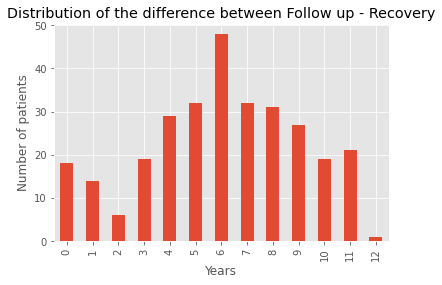

In [86]:
# compute difference between follow up and hospital admission
df_diff = df["Follow Up Data"] - df["Data prelievo (1)"]
for i in df_diff.index:
    df_diff[i] = df_diff[i].days // 365
df_diff.value_counts().sort_index().plot(kind='bar')

plt.title("Distribution of the difference between Follow up - Recovery")
plt.xlabel("Years")
plt.ylabel("Number of patients")

# create the target feature
# years = 7
# survive = (df_diff < years) & df["CVD Death"]
# survive = (survive + 1) % 2

In [85]:
# df_diff.value_counts().sort_index().append(pd.Series({'13':0, '14':0}))

In [18]:
# complete vessels feature
# for i in df.index:
#     if (pd.isna(df["Vessels"][i]) and df["CAD"][i]==0):
#         df.loc[i, "Vessels"] = 0
#     elif (pd.isna(df["Vessels"][i]) and df["CAD"][i]==1):
#         df.loc[i, "Vessels"] = -1
# df.info()

# clean features
# remove dates, follow up features
target = df["CVD Death"]
# df_feat = df.iloc[:, :83]
df_feat = df.copy()
df_feat = pd.concat([df_feat.iloc[:, :30], df_feat.iloc[:, 40:]], axis=1)
df_feat = df_feat.drop(columns=["Patologia TIROIDE ", "Controllo", "Weight", "Height"])
df_feat.info()

# add target feature
df_feat[f"Survive{years}Y"] = survive

# drop all the remaining na patients
# df_feat = df_feat.dropna()
print("Total patient: \t", len(df_feat))
print("Survived: \t", df_feat[f"Survive{years}Y"].sum(), "\t", df_feat[f"Survive{years}Y"].sum()/len(df_feat))
print("Dead: \t\t", len(df_feat)-df_feat[f"Survive{years}Y"].sum(), "\t", (len(df_feat)-df_feat[f"Survive{years}Y"].sum())/len(df_feat))
df_feat.info()

# df_feat.to_csv("data/data/data_cvd.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5820 entries, 395 to 1193
Data columns (total 79 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Age (1)                                     5820 non-null   int64         
 1   Gender (Male = 1)                           5820 non-null   int64         
 2   Angina                                      5820 non-null   int64         
 3   Previous CABG                               5820 non-null   int64         
 4   Previous PCI                                5820 non-null   int64         
 5   Previous 
Myocardial Infarction             5820 non-null   int64         
 6   Acute 
Myocardial Infarction                5820 non-null   int64         
 7   Angiography                                 5820 non-null   int64         
 8   Vessels                                     3562 non-null   float64       
 9   CAD   

In [11]:
# dataset train, valid, test split
def split_and_save(df, path, verbose=True):
    from sklearn.model_selection import train_test_split
    df_train, df_test = train_test_split(df, test_size=0.2, stratify=df.iloc[:,-1])
    df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train.iloc[:,-1])

    df_train.to_csv(f"{path}train.csv")
    df_valid.to_csv(f"{path}valid.csv")
    df_test.to_csv(f"{path}test.csv")

    if verbose: 
        print("Train: \t", len(df_train))
        print("Valid: \t", len(df_valid))
        print("Test: \t", len(df_test))

# # save the whole dataset
# split_and_save(df_feat, "data/data/7y/", overwrite=False)

## Number of patients for each subgroup
- Angina:         2512
- Aritmie:        1508
- PMI:            1278
- Previous PCI:   650
- Post-ischemic:  478
- AMI:            378 
- Previous CABG:  356

In [12]:
# divide into subgroups and save the datasets
# df_angina = df_feat[df_feat["Angina"] == 1]
# df_aritmie = df_feat[df_feat["Aritmie"] == 1]
# df_pmi = df_feat[df_feat["PMI"] == 1]

# split_and_save(df_angina, "data/data/7y/angina/")
# split_and_save(df_aritmie, "data/data/7y/aritmie/")
# split_and_save(df_pmi, "data/data/7y/pmi/")

In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(35,30))
sns.heatmap(df_feat.corr(), annot=True)
# fig.savefig("feat.pdf")